<a href="https://colab.research.google.com/github/Marcosuff/Marcosuff.github.io/blob/master/fastaiv2_works/SMILES_LSTM_fastaiv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#export
import sys
!pip install fastai2
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! bash Anaconda3-2019.10-Linux-x86_64.sh -bfp /usr/local
sys.path.append('/usr/local/lib/python3.7/site-packages')
!conda install -y -c rdkit rdkit

In [ ]:
#export
import pandas as pd
import numpy as np

from fastai2.text.all import *
#from fastai2.callback import *

from IPython.display import display,HTML

from rdkit.Chem import MolFromSmiles, MolToSmiles, AllChem, SanitizeMol, rdmolops
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.SaltRemover import SaltRemover as saltremover
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.info')

from google.colab import drive

In [ ]:
#export
drive.mount('mydrive')
#sys.path.append('/content/mydrive/My Drive/Generative/mol_utils')
path = Path('/content/mydrive/My Drive/Generative/data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at mydrive


# **Import data**

In [ ]:
LM = Path('/content/LM')
LM.mkdir()

In [ ]:
chembl = pd.read_csv(path/'ChEMBL_v2.csv').sample(n=250000)
print(chembl.shape)
db = pd.read_csv(path/'chembl27.csv.gz')

(250000, 3)


In [ ]:
target_name = 'CHEMBL244'
fxa = db[db['target_chembl_id'] == target_name]
print(fxa.shape)
fxa.head()

(6515, 14)


,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score
22,3476,44.4,IC50,=,7.35,192068,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc3ccccc3n2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL117716,194,CHEMBL244,Enzyme,Protease,Serine protease,8
273,6512,180.0,IC50,=,6.75,203908,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1-n1ccccc1=O,CHEMBL337921,194,CHEMBL244,Enzyme,Protease,Serine protease,8
274,6512,120.0,IC50,=,6.92,204329,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1N1CCOCC1=O,CHEMBL340500,194,CHEMBL244,Enzyme,Protease,Serine protease,8
288,3476,311.0,IC50,=,6.51,192044,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CNC(=O)c2cnccn2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL117721,194,CHEMBL244,Enzyme,Protease,Serine protease,8
291,3476,6.1,IC50,=,8.21,191486,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc(O)nc2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL331807,194,CHEMBL244,Enzyme,Protease,Serine protease,8


# **Tokenizing V2**

In [ ]:
#export
class MolTokenizer_v2():

  def tokenize_mols(self, t):
    pat = '(\[.*?\])' # Find special enviroments (e.g., [CH],[NH] etc)
    tokens = []
    t = t.replace('Br','L').replace('Cl','X') # Replace halogens
    atom_list = re.split(pat,t)
    for s in atom_list:
      if s.startswith('['):
        tokens.append(s)
      else:
        tokens += [x for x in list(s)]
    tokens = [x.replace('L','Br').replace('X','Cl') for x in tokens] # Decode halogens
    return [BOS] + tokens

  def __call__(self, items): return (self.tokenize_mols(t) for t in items)

In [ ]:
tk = Tokenizer(MolTokenizer_v2(),rules=[])

In [ ]:
tokens = L(list(chembl.Smiles)).map(tk)
tokens

(#250000) [['xxbos', 'O', '=', 'C', '(', 'N', 'O', ')', 'C', '(', 'C', 'c', '1', 'c', 'c', 'c', 'c', '(', 'O', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', ')', 'c', '1', ')', 'C', '(', '=', 'O', ')', 'N', 'C', 'C', 'C', 'C', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1'],['xxbos', 'C', 'O', 'C', '[C@H]', '(', 'N', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', '(', 'O', 'C', ')', 'n', 'o', '1', ')', 'C', '(', '=', 'O', ')', 'N', '[C@@H]', '(', 'C', 'O', 'C', ')', 'C', '(', '=', 'O', ')', 'N', '[C@@H]', '(', 'C', 'C', '(', 'C', ')', 'C', ')', 'C', '(', '=', 'O', ')', '[C@@]', '1', '(', 'C', ')', 'C', 'O', '1'],['xxbos', 'C', '[C@]', '1', '2', 'C', '=', 'C', 'C', '(', '=', 'O', ')', 'C', '=', 'C', '1', 'C', 'C', '[C@@H]', '1', 'C', '2', '=', 'C', 'C', '[C@]', '2', '(', 'C', ')', 'C', '(', 'C', '(', '=', 'O', ')', 'C', 'O', ')', '=', 'C', 'C', '[C@@H]', '1', '2'],['xxbos', 'C', 'S', '(', '=', 'O', ')', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 'c', '(', 'N', 'c', '2', 'n', 'c', 'n', 'c', '(', 'O', 'C', 

In [ ]:
num = Numericalize(min_freq = 1, special_toks=[BOS,PAD])
num.setup(tokens)

num.vocab

['xxbos',
 'xxpad',
 'c',
 'C',
 '(',
 ')',
 '1',
 'O',
 '2',
 '=',
 'N',
 'n',
 '3',
 'F',
 '4',
 '-',
 '[C@H]',
 'S',
 '[C@@H]',
 'Cl',
 '/',
 '[nH]',
 's',
 'o',
 '5',
 '#',
 '[N+]',
 'Br',
 '\\',
 '[C@]',
 '[O-]',
 '[C@@]',
 'P',
 '6',
 '[n+]',
 'I',
 '7',
 '[N-]',
 '[P+]',
 '8',
 '[s+]',
 '[P@@]',
 '[PH]',
 '[P@]',
 '[o+]',
 '[C-]',
 '[N@+]',
 '[N@]',
 '[N@@]',
 '9',
 '[N@@+]',
 'p',
 '[C+]',
 '%',
 '0',
 '[O+]',
 '[c+]',
 '[S@]',
 '[S@@]',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake',
 'xxfake']

In [ ]:
coll_repr(num.vocab, 15),len(num.vocab)

("(#64) ['xxbos','xxpad','c','C','(',')','1','O','2','=','N','n','3','F','4'...]",
 64)

In [ ]:
#nums10 = tokens[0:10].map(num)
#nums10
num(tokens[1])

TensorText([ 0,  3,  7,  3, 16,  4, 10,  3,  4,  9,  7,  5,  2,  6,  2,  2,  4,  7,
         3,  5, 11, 23,  6,  5,  3,  4,  9,  7,  5, 10, 18,  4,  3,  7,  3,  5,
         3,  4,  9,  7,  5, 10, 18,  4,  3,  3,  4,  3,  5,  3,  5,  3,  4,  9,
         7,  5, 31,  6,  4,  3,  5,  3,  7,  6])

Let's take a look at some batches. When training a language model, we first concatenate all texts into a big stream and then split it into batches with a defined sequence length.

In the case of SMILES strings, at each epoch the model will recieve `bs` number of mini-batches. But instead of sending long SMILES at each epoch (which would crash the GPU memory), we further split the batches into subarrays with a length equals to `seq_len`. These subarrays are split in a manner as to preserve the order within each SMILES string.

In [ ]:
bs,seq_len = 6,15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

"[xxbos, O, =, C, (, N, O, ), C, (, C, c, 1, c, c, c, c, (, O, c, 2, c, c, c, c, c, 2, ), c, 1, ), C, (, =, O, ), N, C, C, C, C, c, 1, c, c, c, c, c, 1]","[xxbos, C, O, C, [C@H], (, N, C, (, =, O, ), c, 1, c, c, (, O, C, ), n, o, 1, ), C, (, =, O, ), N, [C@@H], (, C, O, C, ), C, (, =, O, ), N, [C@@H], (, C, C, (, C, ), C, ), C, (, =, O, ), [C@@], 1, (, C, ), C, O, 1]","[xxbos, C, [C@], 1, 2, C, =, C, C, (, =, O, ), C, =, C, 1, C, C, [C@@H], 1, C, 2, =, C, C, [C@], 2, (, C, ), C, (, C, (, =, O, ), C, O, ), =, C, C, [C@@H], 1, 2]","[xxbos, C, S, (, =, O, ), (, =, O, ), c, 1, c, c, c, (, N, c, 2, n, c, n, c, (, O, C, 3, C, [C@H], 4, C, C, [C@H], (, C, 3, ), N, 4, S, (, C, ), (, =, O, ), =, O, ), c, 2, [N+], (, =, O, ), [O-], ), c, (, F, ), c, 1]","[xxbos, O, =, C, (, C, c, 1, c, c, c, (, F, ), c, (, F, ), c, 1, ), N, C, [C@@H], 1, N, [C@H], (, C, O, ), [C@H], (, O, ), [C@@H], 1, O]","[xxbos, C, N, 1, C, C, C, (, N, c, 2, c, c, c, 3, n, c, c, (, -, c, 4, c, n, n, (, -, c, 5, c, n, c, c, n, 5, ), c, 4, ), n, 3, n, 2, ), C, C, 1]","[xxbos, C, O, c, 1, c, c, c, c, (, [C@H], 2, C, O, C, (, =, O, ), N, 2, c, 2, c, c, n, 3, n, c, c, (, -, c, 4, c, c, c, (, -, c, 5, n, c, [nH], n, 5, ), c, (, F, ), c, 4, ), c, 3, n, 2, ), n, 1]","[xxbos, O, c, 1, n, n, c, (, C, (, F, ), (, F, ), F, ), c, 2, n, n, n, (, C, c, 3, c, c, c, c, c, 3, Cl, ), c, 1, 2]","[xxbos, C, c, 1, c, c, c, c, (, C, ), c, 1, O, c, 1, c, c, (, N, c, 2, c, c, c, (, C, #, N, ), c, c, 2, ), n, c, 2, n, c, n, n, 1, 2]","[xxbos, C, C, O, P, (, =, O, ), (, O, C, C, ), [C@@H], 1, C, [C@H], (, C, (, =, O, ), N, c, 2, c, c, 3, c, 4, c, (, c, c, c, c, 4, c, 2, ), C, (, =, O, ), N, (, C, C, N, (, C, ), C, ), C, 3, =, O, ), O, N, 1, C]","[xxbos, O, =, C, (, c, 1, c, c, 2, c, (, s, 1, ), C, C, N, C, 2, ), N, 1, C, C, N, (, S, (, =, O, ), (, =, O, ), c, 2, c, c, c, 3, c, c, (, Cl, ), c, c, c, 3, c, 2, ), C, C, 1]","[xxbos, C, O, c, 1, c, c, c, (, C, (, =, O, ), O, c, 2, c, c, c, c, 3, c, c, c, n, c, 2, 3, ), c, c, 1, O, C]","[xxbos, C, c, 1, n, c, c, 2, c, c, (, -, c, 3, c, (, Cl, ), c, c, c, c, 3, Cl, ), c, (, N, C, (, =, O, ), c, 3, c, c, o, c, 3, ), n, c, 2, n, 1]","[xxbos, C, N, 1, C, 2, C, (, =, O, ), c, 3, c, c, c, c, c, 3, C, 1, C, 1, =, C, 2, C, (, =, O, ), c, 2, c, c, c, c, c, 2, C, 1, =, O]","[xxbos, C, C, (, C, ), O, C, C, (, =, O, ), N, 1, c, 2, c, c, c, c, c, 2, C, C, c, 2, c, c, c, (, N, C, (, =, O, ), O, C, (, C, ), C, ), c, c, 2, 1]"
"[xxbos, C, C, (, C, ), [P+], (, C, c, 1, c, c, c, (, C, c, 2, c, c, c, (, C, [P+], (, c, 3, c, c, c, c, c, 3, ), (, c, 3, c, c, c, c, c, 3, ), C, (, C, ), C, ), c, c, 2, ), c, c, 1, ), (, c, 1, c, c, c, c, c, 1, ), c, 1, c, c, c, c, c, 1]","[xxbos, F, c, 1, c, c, c, c, c, 1, N, C, 1, C, C, N, C, C, 1]","[xxbos, C, O, c, 1, c, c, c, (, N, C, (, =, O, ), c, 2, c, c, (, Cl, ), c, c, c, 2, O, ), c, c, 1]","[xxbos, C, c, 1, c, c, c, (, S, (, =, O, ), (, =, O, ), C, C, (, =, O, ), N, c, 2, n, n, c, (, C, ), s, 2, ), c, c, 1]","[xxbos, O, c, 1, c, c, c, (, /, N, =, C, /, c, 2, c, c, c, 3, c, c, c, c, c, 3, c, 2, ), c, c, 1]","[xxbos, C, C, n, 1, c, c, (, -, c, 2, c, c, c, (, -, c, 3, c, 4, c, (, n, n, 3, C, ), C, C, c, 3, c, n, c, (, N, c, 5, c, c, c, (, C, (, =, O, ), O, ), c, c, 5, O, C, ), n, c, 3, -, 4, ), c, c, 2, ), c, n, 1]","[xxbos, C, C, O, C, (, =, O, ), N, C, (, =, O, ), C, O, C, (, =, O, ), C, C, C, S, c, 1, n, c, 2, c, c, c, c, c, 2, s, 1]","[xxbos, C, C, N, (, C, C, ), c, 1, c, c, c, (, N, c, 2, c, c, c, (, C, C, c, 3, c, c, c, (, Cl, ), c, (, Cl, ), c, 3, ), c, c, 2, ), c, (, C, (, =, O, ), O, ), c, 1]","[xxbos, C, N, C, c, 1, c, c, c, c, c, 1, O, c, 1, c, c, c, (, Cl, ), c, c, 1]","[xxbos, C, c, 1, c, c, c, (, N, C, (, =, O, ), c, 2, c, (, N, 3, C, (, =, O, ), c, 4, c, c, c, c, c, 4, C, 3, =, O, ), c, (, C, #, N, ), c, 3, n, 2, C, C, C, 3, ), c, c, 1]","[xxbos, C, C, C, C, c, 1, c, c, c, (, N, C, (, =, O, ), N, S, (, =, O, ), (, =, O, ), c, 2, c, c, c, (, C, ), c, c, 2, ), c, c, 1]","[xxbos, C, (, =, N, /, n, 1, c, n, n, c, 1, ), \,

In [ ]:
bs,seq_len = 4,5
d_tokens = np.array([tokens[i*12:i*12+seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

"[xxbos, O, =, C, (, N, O, ), C, (, C, c, 1, c, c, c, c, (, O, c, 2, c, c, c, c, c, 2, ), c, 1, ), C, (, =, O, ), N, C, C, C, C, c, 1, c, c, c, c, c, 1]","[xxbos, C, O, C, [C@H], (, N, C, (, =, O, ), c, 1, c, c, (, O, C, ), n, o, 1, ), C, (, =, O, ), N, [C@@H], (, C, O, C, ), C, (, =, O, ), N, [C@@H], (, C, C, (, C, ), C, ), C, (, =, O, ), [C@@], 1, (, C, ), C, O, 1]","[xxbos, C, [C@], 1, 2, C, =, C, C, (, =, O, ), C, =, C, 1, C, C, [C@@H], 1, C, 2, =, C, C, [C@], 2, (, C, ), C, (, C, (, =, O, ), C, O, ), =, C, C, [C@@H], 1, 2]","[xxbos, C, S, (, =, O, ), (, =, O, ), c, 1, c, c, c, (, N, c, 2, n, c, n, c, (, O, C, 3, C, [C@H], 4, C, C, [C@H], (, C, 3, ), N, 4, S, (, C, ), (, =, O, ), =, O, ), c, 2, [N+], (, =, O, ), [O-], ), c, (, F, ), c, 1]","[xxbos, O, =, C, (, C, c, 1, c, c, c, (, F, ), c, (, F, ), c, 1, ), N, C, [C@@H], 1, N, [C@H], (, C, O, ), [C@H], (, O, ), [C@@H], 1, O]"
"[xxbos, C, c, 1, n, c, c, 2, c, c, (, -, c, 3, c, (, Cl, ), c, c, c, c, 3, Cl, ), c, (, N, C, (, =, O, ), c, 3, c, c, o, c, 3, ), n, c, 2, n, 1]","[xxbos, C, N, 1, C, 2, C, (, =, O, ), c, 3, c, c, c, c, c, 3, C, 1, C, 1, =, C, 2, C, (, =, O, ), c, 2, c, c, c, c, c, 2, C, 1, =, O]","[xxbos, C, C, (, C, ), O, C, C, (, =, O, ), N, 1, c, 2, c, c, c, c, c, 2, C, C, c, 2, c, c, c, (, N, C, (, =, O, ), O, C, (, C, ), C, ), c, c, 2, 1]","[xxbos, C, C, (, C, ), [P+], (, C, c, 1, c, c, c, (, C, c, 2, c, c, c, (, C, [P+], (, c, 3, c, c, c, c, c, 3, ), (, c, 3, c, c, c, c, c, 3, ), C, (, C, ), C, ), c, c, 2, ), c, c, 1, ), (, c, 1, c, c, c, c, c, 1, ), c, 1, c, c, c, c, c, 1]","[xxbos, F, c, 1, c, c, c, c, c, 1, N, C, 1, C, C, N, C, C, 1]"
"[xxbos, C, c, 1, c, c, c, (, N, C, (, =, O, ), c, 2, c, (, N, 3, C, (, =, O, ), c, 4, c, c, c, c, c, 4, C, 3, =, O, ), c, (, C, #, N, ), c, 3, n, 2, C, C, C, 3, ), c, c, 1]","[xxbos, C, C, C, C, c, 1, c, c, c, (, N, C, (, =, O, ), N, S, (, =, O, ), (, =, O, ), c, 2, c, c, c, (, C, ), c, c, 2, ), c, c, 1]","[xxbos, C, (, =, N, /, n, 1, c, n, n, c, 1, ), \, c, 1, c, n, (, C, c, 2, c, c, c, c, c, 2, ), c, 2, c, c, c, c, c, 1, 2]","[xxbos, O, =, C, (, C, O, C, (, =, O, ), C, O, c, 1, c, c, c, c, (, Br, ), c, 1, ), N, c, 1, c, c, c, (, F, ), c, c, 1, F]","[xxbos, C, c, 1, c, c, n, c, (, C, C, N, C, (, =, O, ), c, 2, c, c, 3, c, c, c, c, (, N, 4, C, C, N, (, C, C, c, 5, c, c, c, c, n, 5, ), C, C, 4, ), c, 3, o, 2, ), n, 1]"
"[xxbos, C, C, C, C, n, 1, c, (, -, c, 2, c, c, c, (, O, C, ), c, c, 2, ), n, c, 2, c, c, (, C, (, F, ), (, F, ), F, ), c, c, c, 2, 1]","[xxbos, O, =, C, (, N, C, (, =, O, ), c, 1, c, c, c, c, c, 1, ), N, c, 1, c, c, (, N, 2, C, (, =, O, ), C, 3, =, C, (, C, C, C, C, 3, ), C, 2, =, O, ), c, c, c, 1, Cl]","[xxbos, C, C, C, C, c, 1, n, n, (, -, c, 2, c, c, c, c, c, 2, [N+], (, =, O, ), [O-], ), c, (, C, (, =, O, ), O, ), c, 1, C, c, 1, c, c, c, (, -, c, 2, c, c, c, c, c, 2, -, c, 2, n, n, [nH], n, 2, ), c, c, 1]","[xxbos, C, n, 1, n, c, c, c, 1, -, c, 1, c, c, c, 2, c, (, c, 1, ), /, C, (, =, C, /, c, 1, c, c, c, [nH], 1, ), C, (, =, O, ), N, 2]","[xxbos, C, C, (, C, ), N, c, 1, n, c, (, Cl, ), n, c, (, N, [C@H], (, C, ), c, 2, c, c, c, c, c, 2, ), n, 1]"


# **Creating DataLoaders**

**LMdataLoader**

It's simple to create a dataloader using LMdataLoader

In [ ]:
doc(LMDataLoader)

LMDataLoader(dataset, lens=None, cache=2, bs=64, seq_len=72, num_workers=0, shuffle=False, verbose=False, do_setup=True, pin_memory=False, timeout=0, batch_size=None, drop_last=False, indexed=None, n=None, device=None, *, wif=None, before_iter=None, after_item=None, before_batch=None, after_batch=None, after_iter=None, create_batches=None, create_item=None, create_batch=None, retain=None, get_idxs=None, sample=None, shuffle_fn=None, do_batch=None)
A `DataLoader` suitable for language modeling

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
dls = LMDataLoader(tokens.map(num))

In [ ]:
dls

In [ ]:
it = iter(dl)
x1,y1 = next(it)
x2,y2 = next(it)

As we can see, the first row of the first batche continues on the first row of the next batch. This happens because we split the whole stream of SMILES string using `seq_len`. This way, we preserve the order within the SMILES string. 

In [ ]:
' '.join(num.vocab[o] for o in x1[0][:])

'xxbos C c 1 c c ( - c 2 c s c ( N = C ( N ) N ) n 2 ) c n 1 C xxeos xxbos Br c 1 c c c c ( N c 2 n c n c 3 c c n c c 2 3 ) c 1 N C C N 1 C C O C C 1 xxeos xxbos C O'

In [ ]:
' '.join(num.vocab[o] for o in x2[0][:])

'c 1 c ( O ) c c ( O ) c ( C ( = N ) C c 2 c c c ( O ) c c 2 ) c 1 O xxeos xxbos C C O C ( = O ) c 1 c c 2 c c ( C ( = O ) O ) c c c 2 [nH] 1 xxeos xxbos C C ( = O'

In [ ]:
' '.join(num.vocab[o] for o in x[2][:])

'[C@@H] ( C ( = O ) O ) N 1 C ( = O ) C ( = C ( c 2 c c c c c 2 ) c 2 c c c c c 2 ) S C 1 = S xxeos xxbos C = C 1 [C@@H] ( O C ( = O ) C [C@H] ( c 2 c c c c c 2 ) N ('

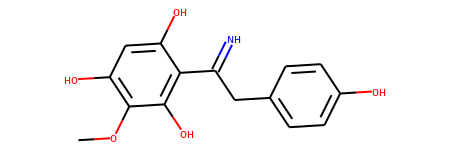

In [ ]:
MolFromSmiles('COc1c(O)cc(O)c(C(=N)Cc2ccc(O)cc2)c1O')

**DataBlock**

We can also use the DataBlock API:

ps> if the text columns isn't called "text", remember to pass ` res_col_name = text_column`. Otherwise, it will return an AttributeError

In [ ]:
d_block = DataBlock(blocks=TextBlock.from_df('Smiles',res_col_name='Smiles',is_lm=True, # Pass is_lm = True since we are training a language model.
                                             tok=MolTokenizer_v2(), rules=[], vocab=num.vocab), # Our tokenizer goes here and we define a minimum of 1
                    get_x=ColReader('Smiles'),
                    splitter=RandomSplitter(0.1)) # Randomply split the data (e.g., 90% for training and 10% for validation)
                    

In [ ]:
dls = d_block.dataloaders(chembl, bs=64, seq_len=30)
dls.show_batch(max_n=2)

**Mid-level API**

First we define the transformations we want to apply. For language models, the basic transformations would be tokenization and numericalization. 

We can put all transformations together using the Pipeline class

In [ ]:
doc(Pipeline)

Pipeline(funcs=None, split_idx=None)
A pipeline of composed (for encode/decode) transforms, setup with types

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
tfms = Pipeline([tk, num])

In [ ]:
t = 'c1ccccc1'
t_num = tfms(t)

In [ ]:
tfms.decode(t_num)

'xxbos c 1 c c c c c 1 xxeos'

`Pipeline` is very useful, but it can't setup the transformations. To properly call `setup` and get the dataset ready, we will use `TfmdLists`

In [ ]:
doc(TfmdLists)

TfmdLists(items, tfms, use_list=None, do_setup=True, split_idx=None, train_setup=True, splits=None, types=None, verbose=False, dl_type=None)
A `Pipeline` of `tfms` applied to a collection of `items`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
doc(Tokenizer.from_df)

Tokenizer.from_df(text_cols, tok=None, rules=None, sep=' ', n_workers=2, mark_fields=None, res_col_name='text', **kwargs)
None

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
tfms = [Tokenizer(tok=MolTokenizer_v2(), rules=[]),
        Numericalize(min_freq=1, special_toks = [UNK, PAD, BOS, EOS])]

tfms = [attrgetter("text"),Tokenizer.from_df(tok=MolTokenizer_v2(), rules=[], text_cols='Smiles', res_col_name = 'Smiles'),
        Numericalize(min_freq=1, special_toks = [UNK, PAD, BOS, EOS])]

In [ ]:
attrgetter

operator.attrgetter

In [ ]:
tls = TfmdLists(chembl,tfms = tfms, splits=splits)

**For some reason using Tokenizer.from_df and Numericalization throws an UnhashbleError**.
Solved by passin attrgetter('Smiles')

In [ ]:
t = tls[7]; t[:20]

tensor([ 2,  4,  8,  5,  9,  5,  5,  5,  5,  6,  4, 12,  4, 11,  6,  4,  4,  4,
         6,  4])

In [ ]:
tls.decode(t)

'xxbos C O c 1 c c c c ( C N C 2 ( C C C ( C ) ( C ) C ) C ( = O ) C ( C 3 = N S ( = O ) ( = O ) c 4 c c ( N S ( C ) ( = O ) = O ) c c c 4 N 3 ) = C ( O ) c 3 c c c c c 3 2 ) c 1 xxeos'

In [ ]:
tls.show(t)

xxbos C O c 1 c c c c ( C N C 2 ( C C C ( C ) ( C ) C ) C ( = O ) C ( C 3 = N S ( = O ) ( = O ) c 4 c c ( N S ( C ) ( = O ) = O ) c c c 4 N 3 ) = C ( O ) c 3 c c c c c 3 2 ) c 1 xxeos


We can access the training and validation sets:


In [ ]:
tls.train[0] # We 

TensorText([ 2,  5,  4,  9,  4,  4,  6, 20,  4, 11,  4, 29,  4,  6, 12, 10,  5,  6,
        12,  7, 12,  7, 15, 11,  7,  4, 15,  9,  5,  3])

In [ ]:
tls.valid[0]

TensorText([ 2, 12, 10,  5,  6, 12,  7, 12,  5,  5,  5, 14,  6, 12,  5,  6, 10,  8,
         7,  5, 14,  6, 12,  5,  6, 10,  8,  7,  5, 14,  6, 12,  7,  5,  6, 10,
         8,  7, 12, 16,  6,  5,  5,  6, 10,  8,  7, 12, 16,  6,  5,  5,  5, 12,
         5,  6, 10, 12,  7, 12,  7,  5,  6, 10,  8,  7,  8,  7,  5,  6, 10,  8,
         7,  8,  7,  5,  6, 10,  8,  7,  8,  7,  5,  6, 10,  8,  7,  8,  3])

We can directly convert `TfmdLists` to dataloaders using the dataloaders method. 

In [ ]:
dls = tls.dataloaders(bs=64,seq_len=30,dl_type=LMDataLoader)

In [ ]:
dls.show_batch()

,text,text_
0,xxbos C C C C ( C ) ( C ) C ( = O ) N [C@H] 1 C C C C N C 1 = O xxeos xxbos,C C C C ( C ) ( C ) C ( = O ) N [C@H] 1 C C C C N C 1 = O xxeos xxbos O
1,c 1 c c c c ( N 2 C C C ( O c 3 c c c n c 3 ) C C 2 ) c 1 F,1 c c c c ( N 2 C C C ( O c 3 c c c n c 3 ) C C 2 ) c 1 F xxeos
2,2 C ) c 1 xxeos xxbos O = C ( C C N C ( = O ) [C@H] ( C c 1 c c c ( - c,C ) c 1 xxeos xxbos O = C ( C C N C ( = O ) [C@H] ( C c 1 c c c ( - c 2
3,1 ) C ( = O ) N 1 C C C [C@H] 1 C O xxeos xxbos C [C@H] 1 C C [C@@H] ( N C c 2 c,) C ( = O ) N 1 C C C [C@H] 1 C O xxeos xxbos C [C@H] 1 C C [C@@H] ( N C c 2 c c
4,C C S c 1 n n c 3 n 1 S ( = O ) ( = O ) c 1 c c c c c 1 N 3,C S c 1 n n c 3 n 1 S ( = O ) ( = O ) c 1 c c c c c 1 N 3 c
5,= O ) C 1 ( C ) C xxeos xxbos C c 1 c c c ( O c 2 n c 3 c c c c c 3,O ) C 1 ( C ) C xxeos xxbos C c 1 c c c ( O c 2 n c 3 c c c c c 3 n
6,c ( C N ) c ( = O ) o c 3 c 2 [C@@H] ( O C ( = O ) [C@@] 2 3 C C [C@] (,( C N ) c ( = O ) o c 3 c 2 [C@@H] ( O C ( = O ) [C@@] 2 3 C C [C@] ( C
7,c 2 c c ( O C ) c c ( O C ) c 2 ) C [C@@H] ( O ) C [C@@H] 1 O xxeos xxbos C C,2 c c ( O C ) c c ( O C ) c 2 ) C [C@@H] ( O ) C [C@@H] 1 O xxeos xxbos C C c
8,c c c ( [C@@] 2 3 O c 4 c c ( O C ) c c ( O C ) c 4 [C@] 2 ( O ) [C@H],c c ( [C@@] 2 3 O c 4 c c ( O C ) c c ( O C ) c 4 [C@] 2 ( O ) [C@H] (


# **Training**

In [ ]:
cut = int(len(chembl)*0.9)
cut

225000

In [ ]:
defaults.text_spec_tok
spec_toks = [BOS, PAD]

In [ ]:
splits = [range(cut), range(cut,len(chembl))] # Split data into train and valid sets (90/10)
tfms = [attrgetter("Smiles"),Tokenizer.from_df(text_cols='Smiles',tok=MolTokenizer_v2(),rules=[],res_col_name='Smiles'),
        Numericalize(min_freq = 1, special_toks=spec_toks)]
dst = Datasets(chembl, tfms=[tfms], splits = splits, dl_type=LMDataLoader)

In [ ]:
dls = dst.dataloaders(bs=64,seq_len=30)

In [ ]:
dls.vocab = [x for x in dls.vocab if x != 'xxfake']
dls.vocab

['xxbos',
 'xxpad',
 'c',
 'C',
 '(',
 ')',
 '1',
 'O',
 '2',
 '=',
 'N',
 'n',
 '3',
 'F',
 '4',
 '-',
 '[C@H]',
 'S',
 '[C@@H]',
 'Cl',
 '/',
 '[nH]',
 's',
 'o',
 '5',
 '#',
 '[N+]',
 'Br',
 '\\',
 '[C@]',
 '[O-]',
 '[C@@]',
 'P',
 '6',
 '[n+]',
 'I',
 '7',
 '[N-]',
 '[P+]',
 '8',
 '[s+]',
 '[P@@]',
 '[PH]',
 '[P@]',
 '[o+]',
 '[C-]',
 '[N@+]',
 '[N@]',
 '[N@@]',
 '9',
 '[N@@+]',
 'p',
 '[C+]',
 '%',
 '0',
 '[O+]',
 '[c+]',
 '[S@]',
 '[S@@]']

In [ ]:
dls.show_batch()

,text,text_
0,xxbos C c 1 c c n c 2 c 1 c ( = O ) c 1 c c c c c 1 n 2 C xxbos F c,C c 1 c c n c 2 c 1 c ( = O ) c 1 c c c c c 1 n 2 C xxbos F c 1
1,c 1 ) = N \ C C 2 xxbos C [C@H] 1 C N = C ( N c 2 c c c c c 2 ) N 1,1 ) = N \ C C 2 xxbos C [C@H] 1 C N = C ( N c 2 c c c c c 2 ) N 1 C
2,C ( F ) ( F ) F ) N 1 C C N ( C c 2 c c c c ( N 3 C C O C C,( F ) ( F ) F ) N 1 C C N ( C c 2 c c c c ( N 3 C C O C C 3
3,c 3 ) n c n c 2 1 ) c 1 c c c ( Br ) c c 1 xxbos C S C C C C ( C,3 ) n c n c 2 1 ) c 1 c c c ( Br ) c c 1 xxbos C S C C C C ( C c
4,) c c 1 xxbos C C N ( C C ) C C C N C c 1 c o c ( - c 2 c c c (,c c 1 xxbos C C N ( C C ) C C C N C c 1 c o c ( - c 2 c c c ( F
5,C C ( = O ) C C C C C [C@H] ( N C ( = O ) C 1 C C N ( C ) C C 1,C ( = O ) C C C C C [C@H] ( N C ( = O ) C 1 C C N ( C ) C C 1 )
6,( C ( F ) ( F ) F ) c 1 ) c 1 c c c c c 1 xxbos C C ( C ) c 1 c,C ( F ) ( F ) F ) c 1 ) c 1 c c c c c 1 xxbos C C ( C ) c 1 c c
7,C [C@@H] ( N C ( = O ) c 1 c c ( C ( = O ) N C c 2 c n c c n 2 ),[C@@H] ( N C ( = O ) c 1 c c ( C ( = O ) N C c 2 c n c c n 2 ) n
8,C 3 ) c c 2 ) = N O 1 xxbos O = C ( N O ) c 1 c c 2 c ( s 1 ) C,3 ) c c 2 ) = N O 1 xxbos O = C ( N O ) c 1 c c 2 c ( s 1 ) C N


In [ ]:
#export
d_block = DataBlock(blocks=TextBlock.from_df('Smiles',res_col_name='Smiles',is_lm=True, # Pass is_lm = True since we are training a language model.
                                             tok=MolTokenizer_v2(), rules=[], min_freq=1), # Our tokenizer goes here and we define a minimum of 1
                    get_x=ColReader('Smiles'),
                    splitter=RandomSplitter(0.1)) # Randomply split the data (e.g., 90% for training and 10% for validation)
dls = d_block.dataloaders(chembl, bs=64, seq_len=30)
dls.show_batch(max_n=5)

,text,text_
0,xxbos C C N ( C C ) C C N 1 N = C ( c 2 c c c ( Br ) c c 2 ) C C,C C N ( C C ) C C N 1 N = C ( c 2 c c c ( Br ) c c 2 ) C C 2
1,F ) c c c 2 S 1 xxeos xxbos C O c 1 c c ( - c 2 n c n ( C ) c 2 - c,) c c c 2 S 1 xxeos xxbos C O c 1 c c ( - c 2 n c n ( C ) c 2 - c 2
2,O = C ( C ( F ) F ) N 1 C C c 2 n c ( N 3 C C C ( O c 4 c c,= C ( C ( F ) F ) N 1 C C c 2 n c ( N 3 C C C ( O c 4 c c c
3,) c c 3 ) n n 1 2 xxeos xxbos C O c 1 c c c ( / C = C / C ( = N / N,c c 3 ) n n 1 2 xxeos xxbos C O c 1 c c c ( / C = C / C ( = N / N C
4,c 1 c c ( - c 2 c s c ( N c 3 c c c c ( C ) c 3 ) n 2 ) c c,1 c c ( - c 2 c s c ( N c 3 c c c c ( C ) c 3 ) n 2 ) c c n


In [ ]:
#export
config = awd_lstm_lm_config.copy()
config.update({'n_hid':512})

In [ ]:
learn = language_model_learner(dls,AWD_LSTM,config=config,drop_mult=0.1,pretrained=False,metrics=[accuracy, Perplexity()])

In [ ]:
learn.fit(5,1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.839070,2.500424,0.255903,12.187662,00:03
1,2.634375,2.365330,0.334201,10.647552,00:03
2,2.483859,2.190485,0.358854,8.939546,00:03
3,2.343545,2.005993,0.417708,7.433473,00:03
4,2.191309,1.811669,0.469097,6.120653,00:03



# **Defining callbacks**

When training a generative chemistry-based model, we are interested in generating valid molecules. By training the previous model long enought we might probably achieve very high accuracies, which translates that the model is doing a great job in predicting the next character in a SMILES string. In fact, this is an indirect evaluation of how good the model is in generating valid molecules. 

Usually we need more flexibility than this. For instance, we might want to inspect how many novel molecules (i.e., not present in training set) can be generated after each epoch. We might also ask if the generated molecules are close to an objective, such as a biological target chemical space. 

To answer these questions, we can use **callbacks**. Callbacks are customizations applied on the model and the training loop that allow us to do basically anything we want. For starters, let's see if we can create a callback to generate 5 molecules after each epoch.

In [ ]:
#export
class MolSampler_V2(Callback):
  def __init__(self, text:str='', max_size:int=30, temperature:float=1.0, max_mols:int=5):
    super().__init__()
    self.text = text
    self.max_size = max_size
    self.temperature = temperature
    self.max_mols = max_mols

  def sampling(self):
    act = getattr(learn.loss_func, 'activation', noop)

    self.model.reset()    # Reset the model
    stop_index = self.dls.train.vocab.index(BOS)        # Define the stop token
    idxs = self.dls.test_dl([self.text]).items[0].to(self.dls.device)
    nums = self.dls.train_ds.numericalize     # Numericalize (used to decode)
    accum_idxs = []                   # Store predicted tokens

    for _ in range(self.max_size):
      with torch.no_grad(): preds=self.model(idxs[None])[0][-1]
      res = act(preds)

      if self.temperature != 1.: res.pow_(1 / self.temperature)
      idx = torch.multinomial(res, 1).item()
      if idx != stop_index:
        accum_idxs.append(idx)
        idxs = TensorText(idxs.new_tensor([idx]))
      else:
        break
    decoded = ''.join([nums.vocab[o] for o in accum_idxs if nums.vocab[o] not in [BOS, PAD]])  # Decode predicted tokens
    return decoded

  def after_epoch(self):
    self.sampling()
    print([self.sampling() for _ in range(self.max_mols)])

In [ ]:
cbs=[MolSampler_V2(), CSVLogger(), SaveModelCallback(monitor='accuracy')]

learn = language_model_learner(dls, AWD_LSTM, pretrained=False,config=config,path=LM,
                               drop_mult=0.1,metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.018478497862815857, lr_steep=6.118806049926206e-05)

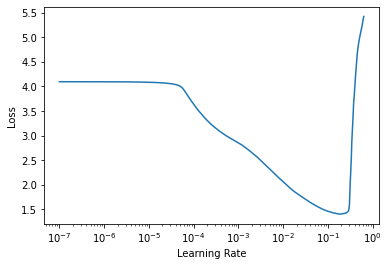

In [ ]:
learn.lr_find(num_it=600)

In [ ]:
learn.fit_one_cycle(n_epoch=7,lr_max=0.001737800776027143,cbs=cbs)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.799168,0.781596,0.732537,2.184957,13:01
1,0.697538,0.682242,0.763715,1.978308,12:53
2,0.667708,0.648523,0.774596,1.912713,12:49
3,0.641927,0.624016,0.783101,1.866408,12:49
4,0.599877,0.598313,0.792236,1.819047,12:46
5,0.570850,0.582207,0.798113,1.789985,12:51
6,0.555107,0.579299,0.799398,1.784787,12:53


['CCCCCCCCCCC)OCc1coc2ccccc12', 'O=C1N[C@H](Cc2ccc(OCc3ccccc3)cc2)C', 'N#Cc1ccn(C2CCSCC2)c2nc(N3CCCCC', 'CC(N1CCN(c2ccccc2)CC1)C(=O)N(C', 'CCOc1ccc(C(C)Nc2ncnc3c2ncn3C)n']
Better model found at epoch 0 with accuracy value: 0.7325373291969299.
['CC(C)(C)C(=O)N[C@@H](Cc1cn(C(=O)Nc2', 'COc1ccc(-n2c(CC3CCN(C(=O)Cc4cc', 'Cc1cnc(N)nc1-n1cc2ccnc(-c3ccc4', 'COc1ccc(S(=O)(=O)N(C)C)c(NC(=O', 'COc1ccc(-c2nc3cc(NC(C)=O)ccc3n']
Better model found at epoch 1 with accuracy value: 0.7637149691581726.
['O=[N+]([O-])c1ccc(CNCc2coc(-c3ccco3)', 'C[C@@H](Oc1ccc(Cn2cnc3c(NN)ncnc32)n', 'CNC[C@H]1CN(c2ccc(F)cc2)c2ccccc2S1', 'Cc1ccc(N2C[C@H]3CS(=O)(=O)[C@H](C(=O)O', 'CCCS(=O)(=O)c1ccc(CCC(OCc2ccc(']
Better model found at epoch 2 with accuracy value: 0.7745956182479858.
['COc1cc(C(=O)N2CCC(C(=O)N(C)Cc3', 'CCC(C)C[C@@H](Oc1nc(=O)cc(C)[nH]1)c1cc', 'CCOC(=O)c1c3ccccc3c(-c2ccc(S(N', 'Cc1ccc(C(=O)NCCN(C)Cc2cc(=O)n(', 'CC1=C(C(=O)N2CCN(Cc3cccc([N+](=O)']
Better model found at epoch 3 with accuracy value: 0.7831006646

In [ ]:
learn.save('fit1')

In [ ]:
learn.load('fit1');

In [ ]:
learn.export()

In [ ]:
learn_inf = load_learner('/content/LM/export.pkl')

In [ ]:
def sampler_test(model, text, temperature, max_size):
  model.model.reset()
  nums = learn.dls.train_ds.numericalize
  idxs = idxs_all = model.dls.test_dl([text]).items[0]#.to(model.dls.device)
  for i in range(max_size):
    print(i)
   # print('begin')
    preds,_ = model.get_preds(dl=[(idxs[None],)])
    res = preds[0][-1]
    if temperature != 1.: res.pow_(1 / temperature)
    idx = torch.multinomial(res, 1).item()
    if idx != 0:
      idxs = idxs_all = torch.cat([idxs_all, idxs.new([idx])])
    else:
      break

  return ''.join([nums.vocab[i] for i in idxs_all if nums.vocab[i] not in [BOS, PAD]])


In [ ]:
mols = [sampler_test(model=learn_inf,text='',temperature=0.7,max_size=120) for _ in range(100)]


How many **valid** molecules did we generate?

In [158]:
valid_mols = [x for x in mols if MolFromSmiles(x)]
print('Percentage of valid SMILES:{:.2f}%'.format(100*len(valid_mols)/len(mols)))

Percentage of valid SMILES:100.00%


How many molecules are **novel** (i.e., not present on the training set)?

In [159]:
novel_mols = set.difference(set(valid_mols),set(chembl.Smiles))
print('Percentage of novel SMILES:{:.2f}%'.format(100*len(novel_mols)/len(valid_mols)))

Percentage of novel SMILES:99.00%


And how many unique SMILES do we have?

In [160]:
unique_mols = set(valid_mols)
print('Percentage of unique SMILES:{:.2f}%'.format(100*len(unique_mols)/len(valid_mols)))

Percentage of unique SMILES:100.00%


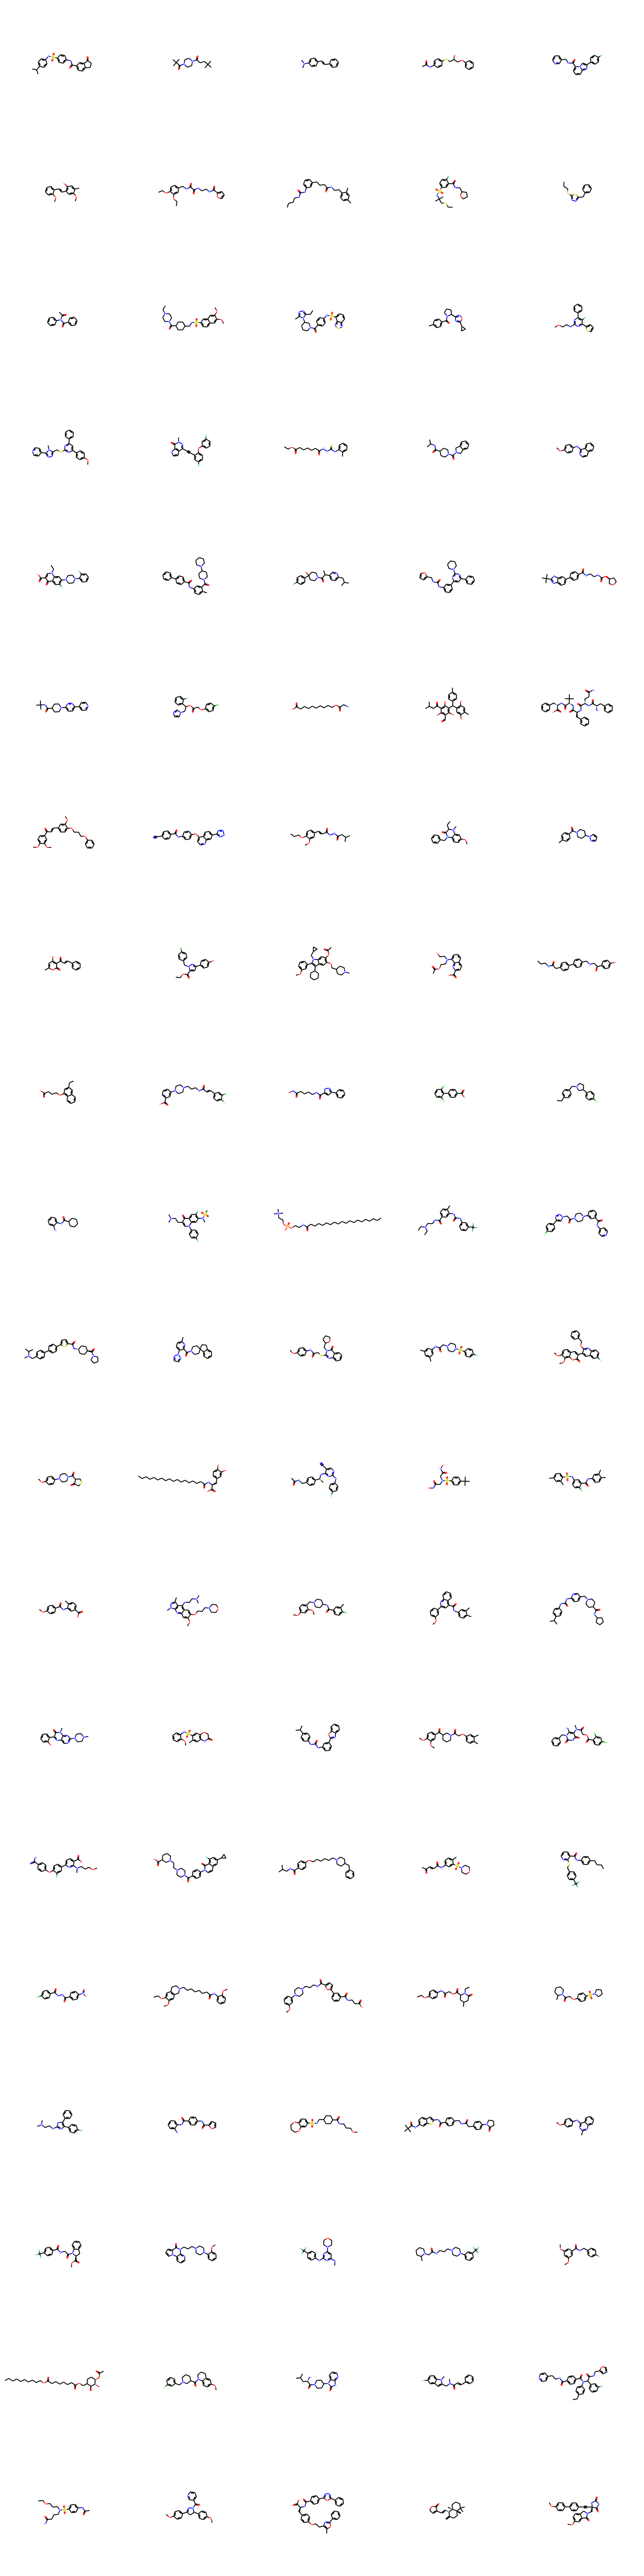

In [154]:
MolsToGridImage(mols = list(map(MolFromSmiles,valid_mols)),maxMols=100,molsPerRow=5,subImgSize=(300,300))

In [155]:
!tar -cvf /content/mydrive/My\ Drive/Blog/fastai_v2_LM.tar.gz /content/LM/*

tar: Removing leading `/' from member names
/content/LM/export.pkl
/content/LM/history.csv
/content/LM/models/
/content/LM/models/.ipynb_checkpoints/
/content/LM/models/model.pth
/content/LM/models/fit1.pth
